In [1]:
from spectrogram import Spectrogram

import matplotlib.pyplot as plt
import numpy as np
import os
from peak_follower import PeakFollower
from jsonDriver import JsonReadDriver #These two driver classes enable reading and writing to JSON files easier
from jsonDriver import JsonWriteDriver
import datetime
import cv2
import argparse

In [2]:
# process command line args
parser = argparse.ArgumentParser()
parser.add_argument('--file_name',type=str,default=False)
parser.add_argument('--peak_follow', type = str,default = True)
parser.add_argument('--manual_start', type = bool, default = True)
parser.add_argument('-json_name',type = str, default = 'CH_1.json')
parser.add_argument('--velocity_cutoff', type = int, default = 10000)
parser.add_argument('--denoise', type=bool,default = False)
parser.add_argument('--colormap', type=str, default = 'viridis', help = "colormap")
parser.add_argument(
        '-f',
        '--file',
        help='Path for input file. First line should contain number of lines to search in'
    )
# parser.add_argument('--process_name',type=)
args = parser.parse_args()

In [3]:
#set the directories that the files will be read from and written to
directory = '/home/max/clinic/dig/pipeline/'
saveTo = '/home/max/clinic/dig/digImages/'

#make a new directory based on the current time and date
a = datetime.datetime.now()
time = ('%02d.%02d-%02d:%02d'%(a.month,a.day,a.hour,a.minute))
try:
    os.mkdir(saveTo + time + '/')
except FileExistsError:
    print("Directory already exists, storing in same directory")
newDirectory = saveTo + time + '/'

In [4]:
#create the class object that will be used to read in the JSON start times
jsondata = JsonReadDriver(args.json_name)

#Create the dictionary to store the succesful runs
jsonwriting = JsonWriteDriver(newDirectory+time+'.json')

In [5]:
def denoise(intensities):
    #convert to 8bit int
    max = np.amax(i)
    data = i/max
    data = data * 255
    data = data.astype(np.uint8)  

    #perform the denoising
    out = cv2.fastNlMeansDenoising(data,None,50,7,21)
    # h = 50, templateWindowSize = 7,searchWindowSize = 21 
    # h is the most relevant, it describes how agressively the algorithm will run
    return out

In [6]:
for filename in os.listdir(directory):
    if filename.endswith(".dig"):
        
        #generate the spectrogram
        spec = Spectrogram(directory+filename)
        t,v,i = spec.slice((spec.t_start,spec.t_end),(0,args.velocity_cutoff))
        
        #get manual start info if required
        if args.manual_start:
            start_coords = jsondata.getManualStart(filename)
        
        #perform peak following
        if (args.peak_follow == True):
            print('running',args.peak_follow)
            peaks = PeakFollower(spec,start_coords)
            peaks.run()
            
            #generate plottable trace information
            trace_v = np.array(peaks.results['velocities'])
            trace_t = np.array(peaks.results['times'])
            jsonwriting.store_time_length(filename,trace_t.size)
            plt.plot(trace_t*1e6,trace_v,color = "red")
      
        #plotting the results
        plt.pcolormesh(t*1e6,v,i,cmap=args.colormap)
        
        #saving the new figure
        plt.savefig(newDirectory + filename+'.png')
        plt.clf()


        continue
    else:
        continue

running True
running True


<Figure size 432x288 with 0 Axes>

In [7]:
#part of the JSON library, a function that ensures all JSON data is written to disk
jsonwriting.flush()
print("done")


done


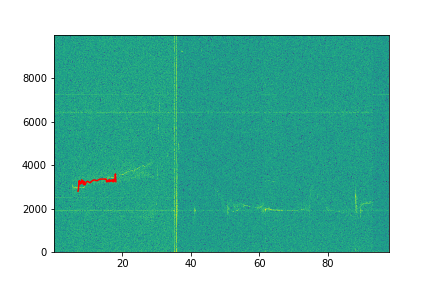

In [8]:
from IPython.display import Image
Image(filename=newDirectory+'seg03.dig.png') 

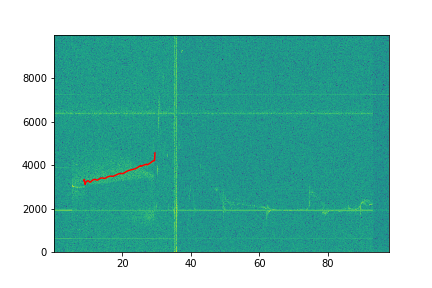

In [9]:
Image(filename=newDirectory+'seg02.dig.png') 

In [11]:
myfile = open(newDirectory+time+'.json')
print(myfile.read())
myfile.close()
        

{
 "seg03.dig": 91,
 "seg02.dig": 170
}
